# Bare surface gradation testing

### Current problem
- level 1 bare surface picks out too much veg
- want to create a level 4 class that will allow for gradation of bare areas  (i.e. 1 = bare areas, unvegetated; 2 = very sparsely vegetated, 3 = sparsely vegetated)

### Ideas
- probably look at using FC, particularly BS endmember
- perhaps look at MADs or LS simple index?
- timeseries info, i.e. bimonthly approach with thresholds like alberts?
- maybe barest earth?

1. BS median, threshold into 3 gradations
2. inverse of canopycover plugin using BS, similar to 1
3. BS bimonthly max or max, threshold into 3 gradations
4. annual mads with simple thresholds into 3 gradations
5. implement alberts approach for unvegetated (maxPV <= 10) and very sparsely vegetated (maxPV < 30) 
6. a few simple soil indices
7. FCcc where BS = 12 months, BS = 6 months, BS = 3 months

#### Current workflow
- on the fly level 3 using Dans interactive code
- select out bare surface (216) class as mask
- create vp's and where statements to classified into gradations

In [1]:
import argparse
import logging
import os, sys, glob
import yaml
import copy

import numpy as np
import xarray as xr

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import datacube
from datacube.storage import masking
from datacube.virtual import catalog_from_file
dc = datacube.Datacube()

sys.path.append(os.path.abspath("/home/jovyan/development/livingearth_australia/le_plugins"))
sys.path.append("/home/jovyan/development/dea-notebooks/Scripts")
sys.path.append("/home/jovyan/development/livingearth_australia")
sys.path.append(os.path.abspath("/home/jovyan/development/livingearth_lccs"))
os.environ["LE_LCCS_PLUGINS_PATH"] = "/home/jovyan/development/livingearth_australia/le_plugins"

# Import le_lccs modules
from le_lccs import le_ingest
from le_lccs import le_export
from le_lccs.le_classification import lccs_l3

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [2]:
yaml_sites_file = os.path.abspath("/home/jovyan/development/chris_leaust_testing/notebooks/misc/au_test_sites.yaml")
config_file = os.path.abspath("/home/jovyan/development/livingearth_australia/templates/l3_vp_template_FCcc.yaml")

with open(yaml_sites_file, "r") as f:
    site_config = yaml.safe_load(f)

site_name = "Brisbane"

extent = [site_config[site_name]["min_x"],
          site_config[site_name]["min_y"],
          site_config[site_name]["max_x"],
          site_config[site_name]["max_y"]]

crs = "EPSG:3577"
res = (-100, 100)
time = ("2015-01-01", "2015-12-31")
query =({'time': time,
             'x':(extent[0],extent[2]),
            'y':(extent[1],extent[3]),
            'crs':crs,
            'resolution':res})

In [3]:
# Read in config file
with open(config_file, "r") as f:
    config = yaml.safe_load(f)

# Set up dictionary to define size parameters
target_size = {}
# If an extent is provided then use this instead of the values
# in the config file
if extent is not None:
    if not isinstance(extent, list) or len(extent) != 4:
        raise TypeError("Extent must be a list with 4 values")

    else:
        target_size["target_min_x"] = extent[0]
        target_size["target_max_x"] = extent[2] - 1000
        target_size["target_min_y"] = extent[1]
        target_size["target_max_y"] = extent[3] - 1000
else:
    target_size["target_min_x"] = config["extent"]["min_x"]
    target_size["target_max_x"] = config["extent"]["max_x"]
    target_size["target_min_y"] = config["extent"]["min_y"]
    target_size["target_max_y"] = config["extent"]["max_y"]

target_size["target_pixel_size_x"] = res[1]
target_size["target_pixel_size_y"] = res[0]

target_size["target_crs"] = crs

# Set up list of input layers to read in
# Try to read all level 3 layers
try:
    input_layers = config["L3layers"]
# If no 'L3layers' defined in the config file
# try 'Layers' (format used for older Level3 only config files)
except KeyError:
    input_layers = config["Layers"]

# Read each into xarray and save to list
logging.info("Reading in data")
variables_xarray_list = []

layer_names = []
for var_name, ingest_parameters in input_layers.items():
    # Don't run any of the 'xarray_maths' classes yet - nead to load all other variables first
    print("Loading: {}".format(var_name))
    import_class_name = ingest_parameters["ingest_class"]
        # Get the class to use for importing
    if import_class_name != "xarray_maths":
        import_class = getattr(getattr(le_ingest, import_class_name.split(".")[0]),
                              import_class_name.split(".")[1])
        # Set up instance of import class
        import_obj = import_class(**target_size)

        # Import
        ingest_parameters["variable_name"] = var_name
        variables_xarray = import_obj.read_to_xarray(**ingest_parameters)
        variables_xarray_list.append(variables_xarray)
        layer_names.append(var_name)

# Merge to a single dataset
classification_data = xr.merge(variables_xarray_list)

# Apply band maths (if any)
logging.info("  Applying band maths")
for var_name, ingest_parameters in input_layers.items():
    import_class_name = ingest_parameters["ingest_class"]
    if import_class_name == "xarray_maths":
        # Set up instance of import class
        variables_xarray_list.append(le_ingest.ingest_base.LEIngest().xarray_maths(
            classification_data, var_name, layer_names,
            ingest_parameters["expstr"]))

# Make new stack with additional layers
classification_data = xr.merge(variables_xarray_list)

# Get dimensions (tuple)
classification_dims = classification_data["vegetat_veg_cat"].dims

# Apply Level 3 classification
logging.info("Applying Level 3 Classification")
level1, level2, level3 = lccs_l3.classify_lccs_level3(classification_data)

# Get colour scheme
red, green, blue, alpha = lccs_l3.colour_lccs_level3(level3)

level3_out_xarray = xr.Dataset(
    {"level1" : (classification_dims, level1),
     "level2" : (classification_dims, level2),
     "level3" : (classification_dims, level3),
     "Red" : (classification_dims, red),
     "Green" : (classification_dims, green),
     "Blue" : (classification_dims, blue)},
    coords=classification_data.coords)

# get bare surface mask
BS_mask = level3_out_xarray.level3 == 216

Loading: vegetat_veg_cat
Loading: fc_veg


/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


Loading: beaches_mudflats
Loading: wcf_mask


/env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
/env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.3 when using version 0.23.1. This might lead to breaking code or invalid resul

Loading: cultman_agr_cat


/env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.21.3 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Loading: tf_urban_classification
Loading: mads_urban_mask_sdev
Loading: mads_urban_mask_edev
Loading: artific_urb_cat
Loading: wofs_mask
Loading: item_v2_mask
Loading: mangrove


Loading: aquatic_wat_cat


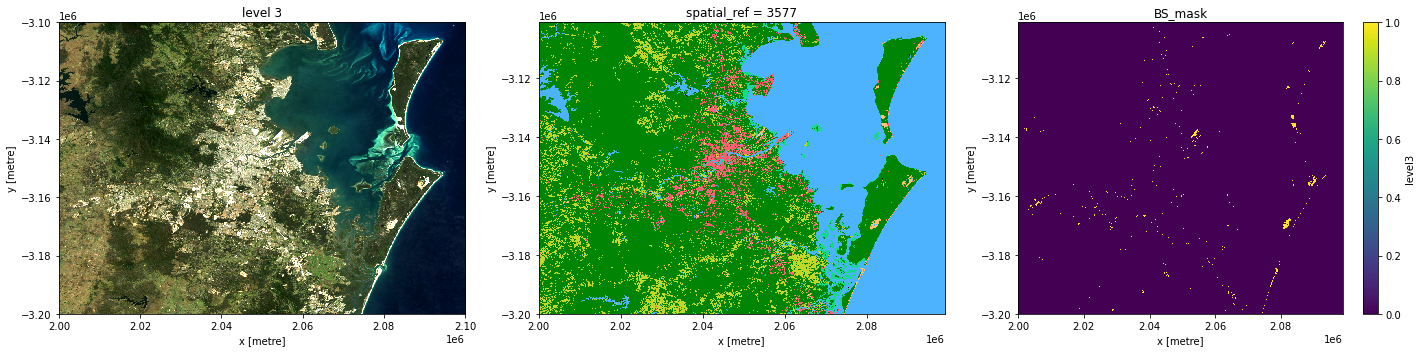

In [4]:
# Load geomedian
geomedian = dc.load(product="ls8_nbart_geomedian_annual", **query)
geomedian = masking.mask_invalid_data(geomedian).squeeze().drop('time')

plt.figure(figsize=(20,5))
gs = gridspec.GridSpec(1,3)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
level3_out_xarray[['Red', 'Green', 'Blue']].to_array().plot.imshow(robust=True)
ax1.set_title('level 3')

ax3=plt.subplot(gs[0,2])
BS_mask.plot.imshow()
ax3.set_title('BS_mask')

plt.tight_layout()
plt.show()

#### idea 1. BS median, threshold into 3 gradations


In [5]:
# datacube functions to load in a virtual product from recipe
catalog = catalog_from_file('/home/jovyan/development/chris_leaust_testing/notebooks/misc/virtual_product_cat.yaml')

In [6]:
# load fc wofs mask (already masked out by water flag from wofs as nan values in vp)
product = catalog['ls_fc_wofs_masked']
ls_fc_wofs_masked = product.load(dc, **query)

# add water (no masking applied here, just raw wofs, so no nans at present)
product = catalog['wofs_daily']
wofs = product.load(dc, **query)
ls_fc_wofs_masked['water'] = wofs.water

In [7]:
data = ls_fc_wofs_masked
data_nan = masking.mask_invalid_data(data)

# Create water and low-quality fc masks
no_water = np.invert( (data['water'] == 128) | (data['water'] == 132) )
high_ue = (data['UE'] > 30) & no_water

# Set to null areas with high UE, but no water
data_nan = data_nan.where(np.invert(high_ue))

# Don't need this anymore
data_nan = data_nan.drop("UE")
del high_ue

# BS median
data_median = data_nan.median(dim='time')

# get data median values of BS mask, masking out zero values
data_median_mask = data_median * BS_mask
data_median_mask = data_median_mask.where(data_median_mask > 0)

# make 3 groups based on median value
BS_median = copy.deepcopy(data_median['BS'])
BS_median.values = np.zeros_like(data_median['BS'], dtype='float64')

BS_median.values = np.where(((data_median['BS'] > 0) & (data_median['BS'] <= 33)), 3, BS_median.values)
BS_median.values = np.where(((data_median['BS'] > 33) & (data_median['BS'] <= 66)), 2, BS_median.values)
BS_median.values = np.where(((data_median['BS'] > 66) & (data_median['BS'] <= 100)), 1, BS_median.values)

# get BS median values of BS mask, masking out zero values
Idea1 = BS_median * BS_mask
Idea1_nan = Idea1.where(Idea1 > 0)

In [8]:
# brown = bare areas, unvegetated 
# orange = very sparsely vegetated 
# green = sparsely vegetated
from matplotlib.colors import from_levels_and_colors
cmap, norm = from_levels_and_colors([0.5,1.5,2.5,3.5],['#61380B','#DBA901','#86B404'])

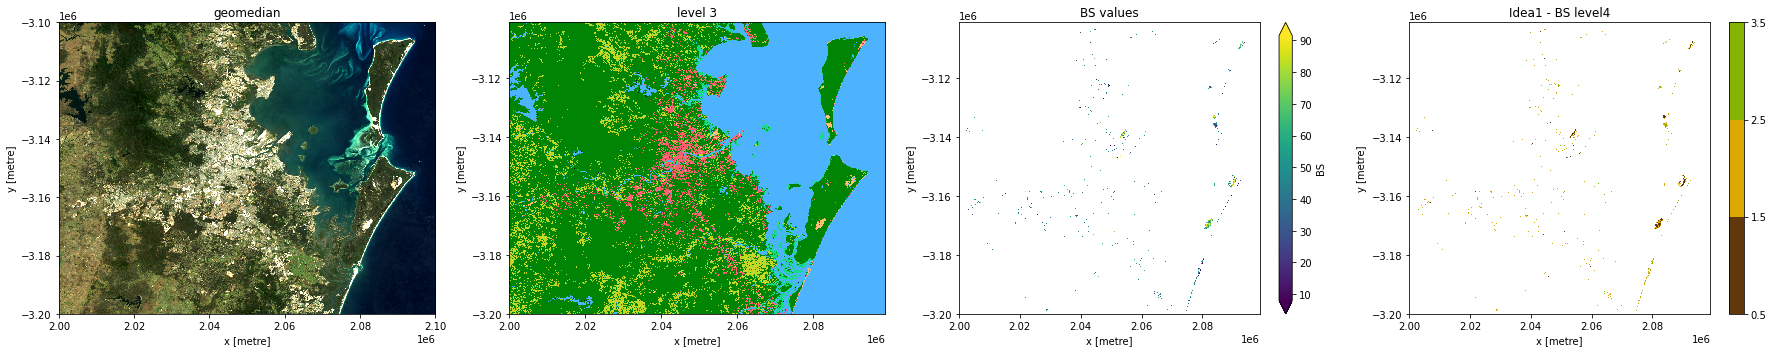

In [9]:
plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(1,4)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
level3_out_xarray[['Red', 'Green', 'Blue']].to_array().plot.imshow(robust=True)
ax2.set_title('level 3')

ax3=plt.subplot(gs[0,2])
data_median_mask.BS.plot.imshow(robust=True)
ax3.set_title('BS values')

ax4=plt.subplot(gs[0,3])
Idea1_nan.plot.imshow(cmap=cmap, norm=norm)
ax4.set_title('Idea1 - BS level4')

plt.tight_layout()
plt.show()

#### idea 2. inverse of canopycover plugin, but using BS endmember

In [10]:
data = ls_fc_wofs_masked
data_nan = masking.mask_invalid_data(data)

# identical to canopycover plugin but using BS instead of PV
data_nan['BS'] = data_nan.BS.where(data_nan.UE < 30)
BS_median = data_nan.BS.median(axis=0)

BS_cover = np.where(((BS_median <= 100) & (BS_median >= 1)), BS_median, 0)
BS_cover_array = xr.DataArray(BS_cover, coords=BS_median.coords, dims=BS_median.dims, attrs=BS_median.attrs)

# get BS cover values of BS mask, masking out zero values
BS_cover_array_mask = BS_cover_array * BS_mask
BS_cover_array_mask = BS_cover_array_mask.where(BS_cover_array_mask > 0)

In [11]:
# make 3 groups based on median value - same as canopycover
BS_cover_groups = copy.deepcopy(BS_cover_array)
BS_cover_groups.values = np.zeros_like(BS_cover_groups, dtype='float64')

BS_cover_groups.values = np.where(((BS_cover_array > 0) & (BS_cover_array <= 20)), 3, BS_cover_groups.values)
BS_cover_groups.values = np.where(((BS_cover_array > 20) & (BS_cover_array <= 60)), 2, BS_cover_groups.values)
BS_cover_groups.values = np.where(((BS_cover_array > 60) & (BS_cover_array <= 100)), 1, BS_cover_groups.values)

# get BS median values of BS mask, masking out zero values
Idea2 = BS_cover_groups * BS_mask
Idea2_nan = Idea2.where(Idea2 > 0)

In [12]:
# brown = bare areas, unvegetated 
# orange = very sparsely vegetated 
# green = sparsely vegetated
from matplotlib.colors import from_levels_and_colors
cmap, norm = from_levels_and_colors([0.5,1.5,2.5,3.5],['#61380B','#DBA901','#86B404'])

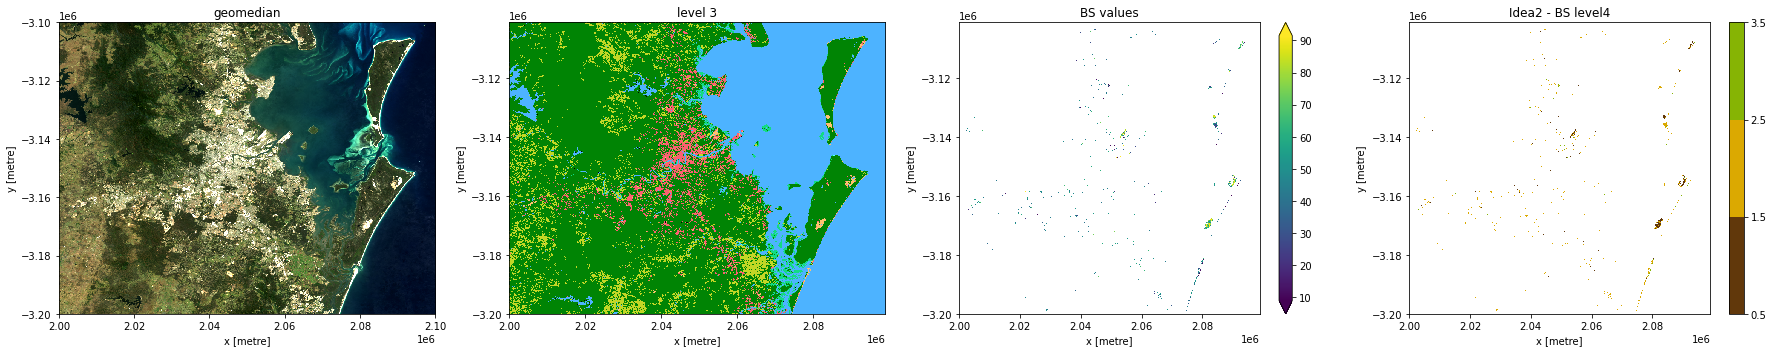

In [13]:
plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(1,4)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
level3_out_xarray[['Red', 'Green', 'Blue']].to_array().plot.imshow(robust=True)
ax2.set_title('level 3')

ax3=plt.subplot(gs[0,2])
BS_cover_array_mask.plot.imshow(robust=True)
ax3.set_title('BS values')

ax4=plt.subplot(gs[0,3])
Idea2_nan.plot.imshow(cmap=cmap, norm=norm)
ax4.set_title('Idea2 - BS level4')

plt.tight_layout()
plt.show()

#### idea 3. BS bimonthly max or max, threshold into 3 gradations


In [14]:
## basically first step is to get good data for FC observations ##
# change of name so works with consecutive count function
data = ls_fc_wofs_masked
# mask_invalid_data used here as some of the FC fractions may contain -ve values so this makes sure everything goes from 0-100%
# doesn't change anything for water dataset (as no nans in product at present)
data_nan = masking.mask_invalid_data(data)

# Create water and low-quality fc masks
# create dataset no water present: water (0) and no water (1) (128 clear and wet; 132 clear and wet and sea)
# invert used here otherwise would be water (1) and no water (0)
no_water = np.invert((data['water'] == 128) | (data['water'] == 132))

# where uncertainty error of pixel is high (i.e. > 30) and no water is present (1)
# this is to remove bad terrestrial data that we not picked up by the water mask of the vp
high_ue_no_water = (data['UE'] > 30) & no_water

# Set to null areas with high UE, but no water
data_nan = data_nan.where(np.invert(high_ue_no_water))

# Don't need UE anymore, done its job
data_nan = data_nan.drop("UE")

# Where there's water, set PV to 0
data_nan['PV'] = data_nan.PV.where(no_water, 0)
data_nan['NPV'] = data_nan.NPV.where(no_water, 0)

# Where there's water, set BS to 100
data_nan['BS'] = data_nan.BS.where(no_water, 0)

# Where there's water, set water to 1
# invert no water (1) to water (could have mad a water mask before to stop inverting things, but this does the job for now)
water = np.invert(no_water)
# Where there's no water on our data_nan product set water to 0
data_nan['water'] = data_nan.water.where(water, 0)
# Where there's values for water that are 0, keep, otherwise all other values make 1
data_nan['water'] = data_nan.water.where(data_nan['water'] == 0, 1)

# now mask out nan values of water using FC
PV = data_nan.PV.isnull()
data_nan = data_nan.where(np.invert(PV))

# Resample to combine each 2 months of data into a median composite
data_bimonthly = data_nan.resample(time='2m', closed='left').median()

# Calculate summary bimonthly metrics
medWater = data_bimonthly.water.median(dim='time')
minPV = data_bimonthly.PV.min(dim='time')
maxPV = data_bimonthly.PV.max(dim='time')
minNPV = data_bimonthly.NPV.min(dim='time')
maxNPV = data_bimonthly.NPV.max(dim='time')
minBS = data_bimonthly.BS.min(dim='time')
maxBS = data_bimonthly.BS.max(dim='time')

#### idea 3a BSmin

In [15]:
# get minBS values of BS mask, masking out zero values
data_minBS_mask = minBS * BS_mask
data_minBS_mask = data_minBS_mask.where(data_minBS_mask > 0)

# make 3 groups based on median value
minBS_gradation = copy.deepcopy(minBS)
minBS_gradation.values = np.zeros_like(minBS, dtype='float64')

minBS_gradation.values = np.where(((minBS > 0) & (minBS <= 33)), 3, minBS_gradation.values)
minBS_gradation.values = np.where(((minBS > 33) & (minBS <= 66)), 2, minBS_gradation.values)
minBS_gradation.values = np.where(((minBS > 66) & (minBS <= 100)), 1, minBS_gradation.values)

# get BS median values of BS mask, masking out zero values
Idea3a = minBS_gradation * BS_mask
Idea3a_nan = Idea3a.where(Idea3a > 0)

In [16]:
# brown = bare areas, unvegetated 
# orange = very sparsely vegetated 
# green = sparsely vegetated
from matplotlib.colors import from_levels_and_colors
cmap, norm = from_levels_and_colors([0.5,1.5,2.5,3.5],['#61380B','#DBA901','#86B404'])

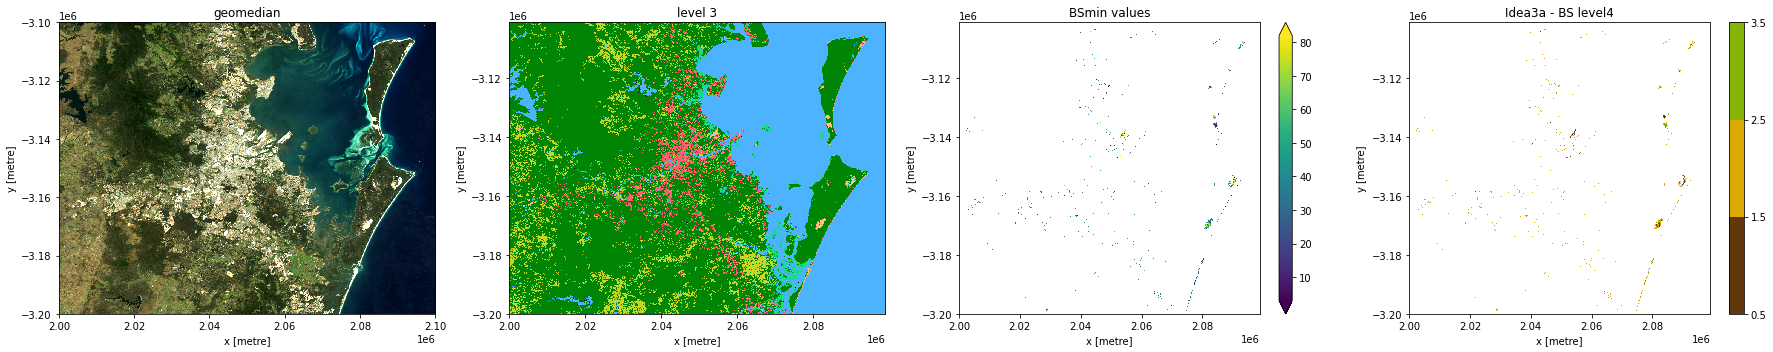

In [17]:
plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(1,4)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
level3_out_xarray[['Red', 'Green', 'Blue']].to_array().plot.imshow(robust=True)
ax2.set_title('level 3')

ax3=plt.subplot(gs[0,2])
data_minBS_mask.plot.imshow(robust=True)
ax3.set_title('BSmin values')

ax4=plt.subplot(gs[0,3])
Idea3a_nan.plot.imshow(cmap=cmap, norm=norm)
ax4.set_title('Idea3a - BS level4')

plt.tight_layout()
plt.show()

#### idea 3b BSmax

In [18]:
# get maxBS values of BS mask, masking out zero values
data_maxBS_mask = maxBS * BS_mask
data_maxBS_mask = data_maxBS_mask.where(data_maxBS_mask > 0)

# make 3 groups based on median value
maxBS_gradation = copy.deepcopy(maxBS)
maxBS_gradation.values = np.zeros_like(maxBS, dtype='float64')

maxBS_gradation.values = np.where(((maxBS > 0) & (maxBS <= 33)), 3, maxBS_gradation.values)
maxBS_gradation.values = np.where(((maxBS > 33) & (maxBS <= 66)), 2, maxBS_gradation.values)
maxBS_gradation.values = np.where(((maxBS > 66) & (maxBS <= 100)), 1, maxBS_gradation.values)

# get BS median values of BS mask, masking out zero values
Idea3b = maxBS_gradation * BS_mask
Idea3b_nan = Idea3b.where(Idea3b > 0)

In [19]:
# brown = bare areas, unvegetated 
# orange = very sparsely vegetated 
# green = sparsely vegetated
from matplotlib.colors import from_levels_and_colors
cmap, norm = from_levels_and_colors([0.5,1.5,2.5,3.5],['#61380B','#DBA901','#86B404'])

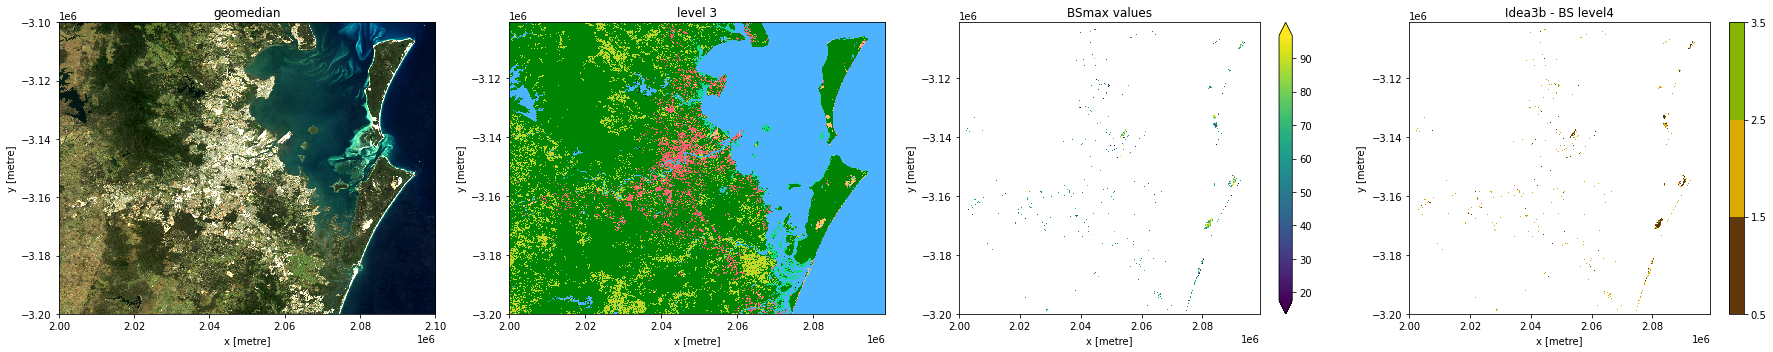

In [20]:
plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(1,4)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
level3_out_xarray[['Red', 'Green', 'Blue']].to_array().plot.imshow(robust=True)
ax2.set_title('level 3')

ax3=plt.subplot(gs[0,2])
data_maxBS_mask.plot.imshow(robust=True)
ax3.set_title('BSmax values')

ax4=plt.subplot(gs[0,3])
Idea3b_nan.plot.imshow(cmap=cmap, norm=norm)
ax4.set_title('Idea3b - BS level4')

plt.tight_layout()
plt.show()

#### viewing all BS continuous values and see the actual differences
- results: probably doesn't really matter which BS summary product is used, likely more the inherent problems in FC (i.e. red soils are usually identified as high BS even when sparsely vegetated)
- also it would see that the gradation categories are more important and what thresholds to use than the summary BS product

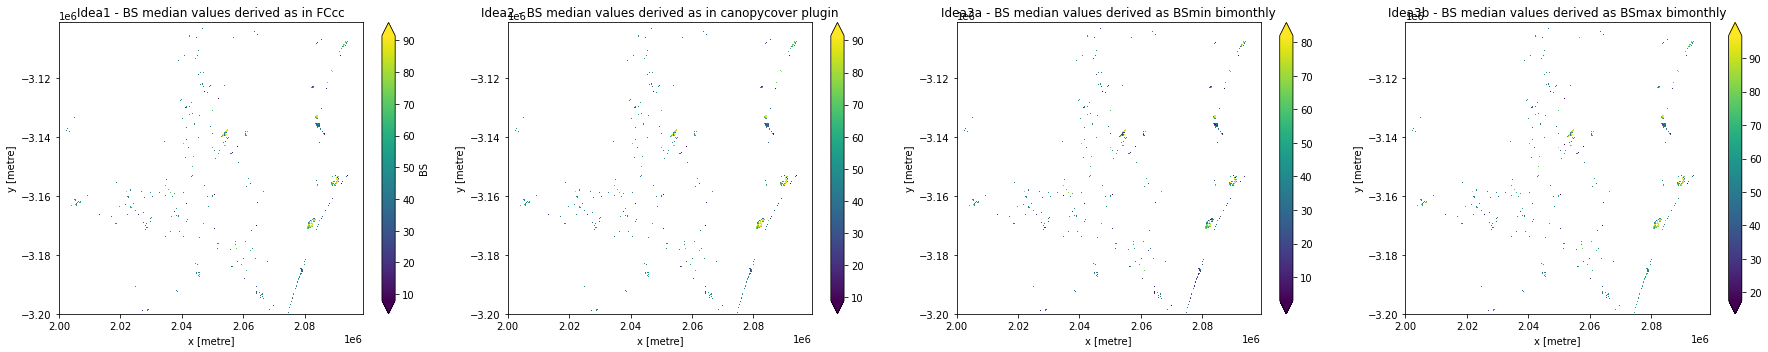

In [21]:
plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(1,4)

ax1=plt.subplot(gs[0,0])
data_median_mask.BS.plot.imshow(robust=True)
ax1.set_title('Idea1 - BS median values derived as in FCcc')

ax2=plt.subplot(gs[0,1])
BS_cover_array_mask.plot.imshow(robust=True)
ax2.set_title('Idea2 - BS median values derived as in canopycover plugin')

ax3=plt.subplot(gs[0,2])
data_minBS_mask.plot.imshow(robust=True)
ax3.set_title('Idea3a - BS median values derived as BSmin bimonthly')

ax4=plt.subplot(gs[0,3])
data_maxBS_mask.plot.imshow(robust=True)
ax4.set_title('Idea3b - BS median values derived as BSmax bimonthly')

plt.tight_layout()
plt.show()

/env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6619: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


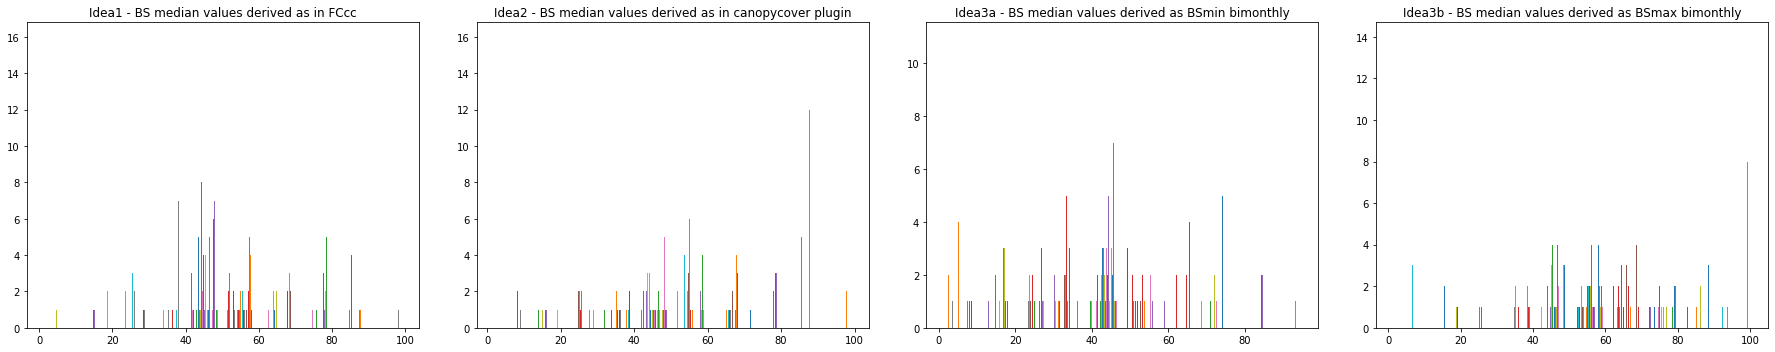

In [22]:
plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(1,4)

ax1=plt.subplot(gs[0,0])
plt.hist(data_median_mask.BS.values)
ax1.set_title('Idea1 - BS median values derived as in FCcc')

ax2=plt.subplot(gs[0,1])
plt.hist(BS_cover_array_mask.values)
ax2.set_title('Idea2 - BS median values derived as in canopycover plugin')

ax3=plt.subplot(gs[0,2])
plt.hist(data_minBS_mask.values)
ax3.set_title('Idea3a - BS median values derived as BSmin bimonthly')

ax4=plt.subplot(gs[0,3])
plt.hist(data_maxBS_mask.values)
ax4.set_title('Idea3b - BS median values derived as BSmax bimonthly')

plt.tight_layout()
plt.show()

#### idea 4. annual mads with simple thresholds into 3 gradations
- result: tested a few sites and mads is not really useful here, probs best to focus on FC or geomedian

In [23]:
# load best_pixel_mad from vp)
product = catalog['best_pixel_mad']
best_pixel_mad = product.load(dc, **query)

# get mad values of BS mask, masking out zero values
best_pixel_mad_mask = best_pixel_mad * BS_mask
best_pixel_mad_mask = best_pixel_mad_mask.where(best_pixel_mad_mask > 0)

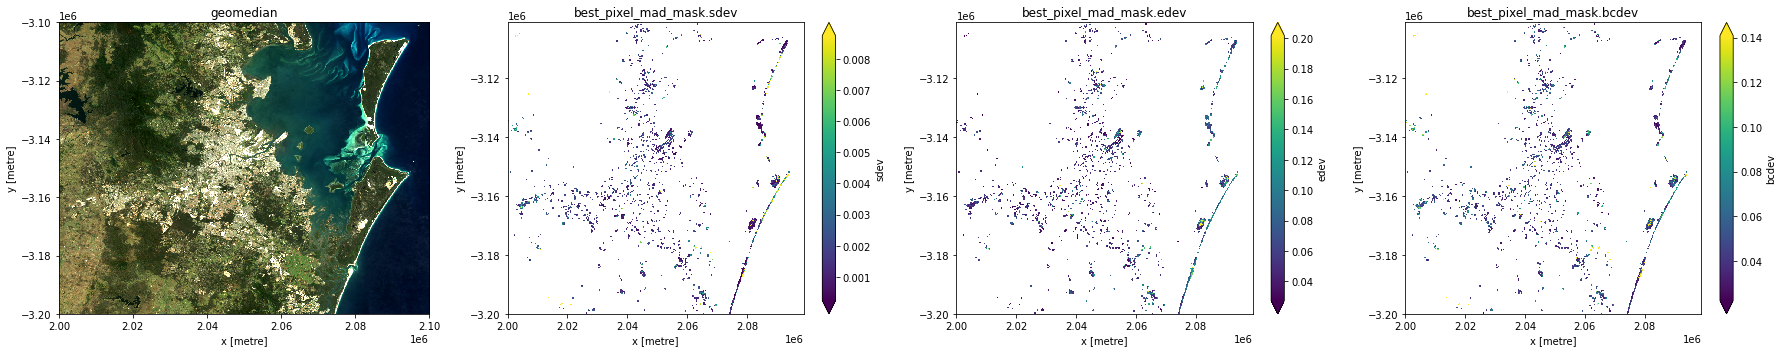

In [24]:
plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(1,4)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
best_pixel_mad_mask.sdev.plot(robust=True)
ax2.set_title('best_pixel_mad_mask.sdev')

ax3=plt.subplot(gs[0,2])
best_pixel_mad_mask.edev.plot(robust=True)
ax3.set_title('best_pixel_mad_mask.edev')

ax4=plt.subplot(gs[0,3])
best_pixel_mad_mask.bcdev.plot(robust=True)
ax4.set_title('best_pixel_mad_mask.bcdev')

plt.tight_layout()
plt.show()

#### idea 5. implement alberts approach for unvegetated (maxPV <= 10) and very sparsely vegetated (maxPV < 30) 

In [25]:
# get maxPV values of BS mask, masking out zero values
data_maxPV_mask = maxPV * BS_mask
data_maxPV_mask = data_maxPV_mask.where(data_maxPV_mask > 0)

albert_bimonthly = copy.deepcopy(maxPV)
albert_bimonthly.values = np.zeros_like(maxPV, dtype='float64')

albert_bimonthly.values = np.where(((maxPV > 0) & (maxPV <= 10)), 1, albert_bimonthly.values)
albert_bimonthly.values = np.where(((maxPV > 10) & (maxPV < 30)), 2, albert_bimonthly.values)
albert_bimonthly.values = np.where(((maxPV >= 30) & (maxPV <= 100)), 3, albert_bimonthly.values)

# get BS median values of BS mask, masking out zero values
Idea5 = albert_bimonthly * BS_mask
Idea5_nan = Idea5.where(Idea5 > 0)

In [26]:
# brown = bare areas, unvegetated 
# orange = very sparsely vegetated 
# green = sparsely vegetated
from matplotlib.colors import from_levels_and_colors
cmap, norm = from_levels_and_colors([0.5,1.5,2.5,3.5],['#61380B','#DBA901','#86B404'])

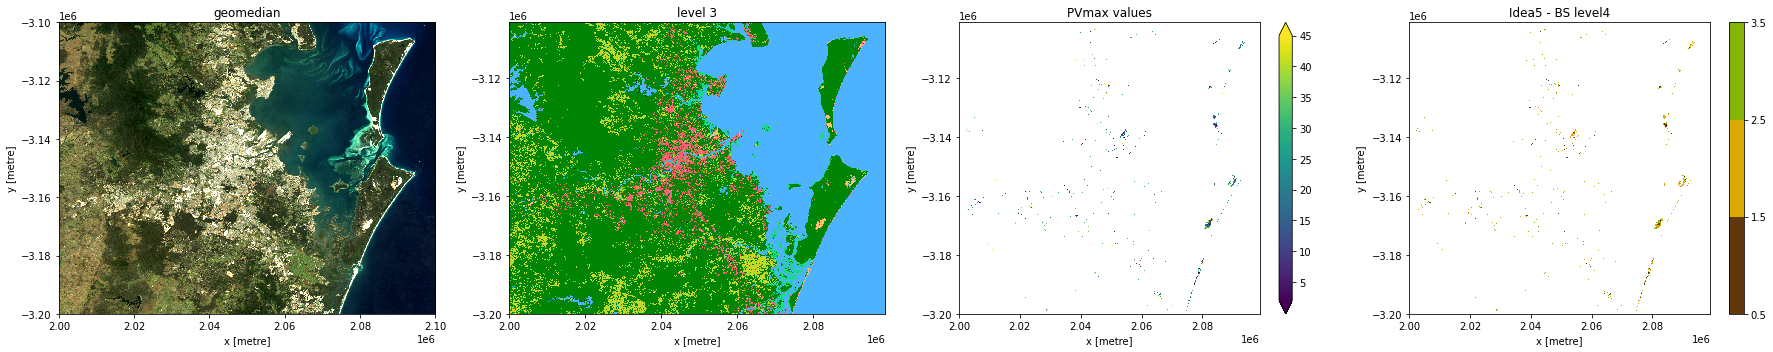

In [27]:
plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(1,4)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
level3_out_xarray[['Red', 'Green', 'Blue']].to_array().plot.imshow(robust=True)
ax2.set_title('level 3')

ax3=plt.subplot(gs[0,2])
data_maxPV_mask.plot.imshow(robust=True)
ax3.set_title('PVmax values')

ax4=plt.subplot(gs[0,3])
Idea5_nan.plot.imshow(cmap=cmap, norm=norm)
ax4.set_title('Idea5 - BS level4')

plt.tight_layout()
plt.show()